## $\mu_1=3.0$，$\mu_2 = \mu_3 =0.0$，$\sigma^2=1$，各群の標本サイズが5のときに，$H_0: \mu_2 = \mu_3$がどれぐらいの確率で棄却されるか？

<a href="https://biolab.sakura.ne.jp/anova-post-hoc-multiple-comparison.html">井口（2020）</a>にて，＜一元配置分散分析において，F検定で有意な場合のみに通常のTukey検定を行うと，検出力で損する＞ことが指摘されています．

一方，永田・吉田（1997, p.32）や，Hsu（p.39）で述べられているように，＜3群のときだけは，制約付きFisherのLSD法は，仮説全体の過誤（FWE: familywise error）を守る＞ことが知られています．

また，（信頼区間には興味がなく，検定だけに興味があるのであれば，）＜ステップダウン法は，通常のTukey法などの同時信頼領域方式よりも，検出力が高い＞ことが知られています．

以下では，3群で $\mu_1=3.0$，$\mu_2 = \mu_3 =0$，$\sigma^2=1$，各群の標本サイズが5である場合，ステップダウン法（FisherのLSD法と，ステップダウンのTukey法）と，通常のTukey法（同時信頼領域方式のTukey法）で，名目的な有意水準を5%としたとき， $H_0: \mu_2 = \mu_3$に対する検定の実質的な有意水準がどれぐらいになるのか，乱数シミュレーションで比較してみました．名目的な有意水準を5%にした検定では，実際に5%の確率で棄却されるのが望ましいです．

検定だけに興味があるならば，（F検定を行わない）通常のTukey検定は検出力の点で損をします．よって，もしも＜一元配置分散分析において，F検定で有意な場合のみに通常のTukey検定を行うと，検出力で損する＞ことを批判するならば，通常のTukey検定も批判すべきだと思います．

（注：4群以上のステップダウン方式は複雑になります．3群の場合は，最初に$H_0: \mu_1 = \mu_2 = \mu_3$の検定をした後，それが有意であれば，通常のペア比較をすればいいだけになっています．）


### 文献
井口豊（2020）分散分析の下位に多重検定を置くな 
https://biolab.sakura.ne.jp/anova-post-hoc-multiple-comparison.html

永田靖・吉田道弘（1997）『統計的多重比較法の基礎』サイエンティスト社

Hsu, J. (1996), _Multiple Comparisons: Theory and Methods_, Chapman and Hall


[1] 0.0504
[1] 0.0207
[1] 0.0504


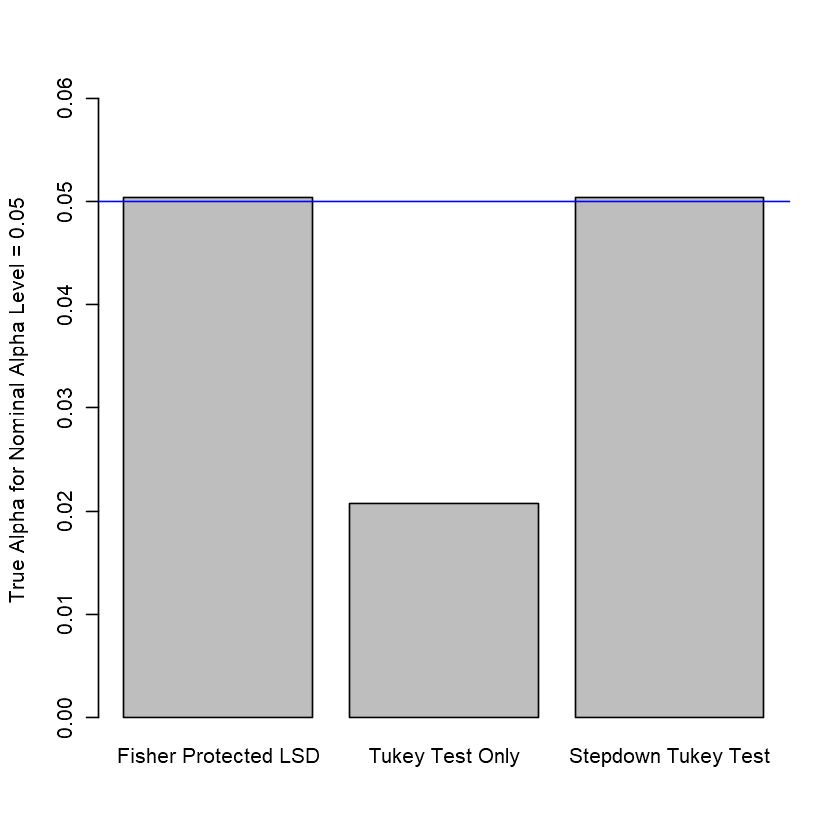

In [1]:
n_group = 3
n_in_each_group = 5
n = n_group * n_in_each_group
dfe = n - n_group
mu = rep(c(3.0, rep(0, n_group - 1)), n_in_each_group)
group = factor(rep(1:n_group, n_in_each_group))
x = model.matrix(~-1 + group, group)
dh = solve(t(x) %*% x) %*% t(x)
h = x %*% solve(t(x) %*% x) %*% t(x)

qf = qf(0.95, 2, dfe)
qt = qt(0.975, dfe)
q_tukey = qtukey(0.95, n_group, dfe) / sqrt(2) ###2.66775681705548 ## Calculated by Tukey HSD Quantile(0.95, 3, 12) on JMP ##

n_sig_LSD = 0
n_sig_Tukey = 0
n_sig_Tukey_stepdown = 0

n_sim = 10000

set.seed(4321)

for(i in 1:n_sim){
    y = mu + rnorm(n_group * n_in_each_group)
    mean = dh %*% y
    ypred = h %*% y
    sse = sum((y - ypred)**2)
    mse = sse / dfe
    ssh = sum((ypred - mean(y))**2)
    f = (ssh / 2) / mse
    sig_anova =  f > qf
    se = sqrt((2 / n_in_each_group) * mse)
    d12 = mean[1] - mean[2]
    d13 = mean[1] - mean[3]
    d23 = mean[2] - mean[3]
    t12 = abs(d12 / se)
    t13 = abs(d13 / se)
    t23 = abs(d23 / se)
    max_t = max(t12, t13, t23)
    sig_Tukey_all = (max_t > q_tukey)
    sig_Tukey = (t23 > q_tukey)
    sig_unadj = (t23 > qt)

    n_sig_LSD = n_sig_LSD + as.numeric(sig_anova & sig_unadj)
    n_sig_Tukey = n_sig_Tukey + as.numeric(sig_Tukey)
    n_sig_Tukey_stepdown = n_sig_Tukey_stepdown + as.numeric(sig_Tukey_all & sig_unadj)
}
        
prob_sig_LSD = n_sig_LSD / n_sim
prob_sig_Tukey = n_sig_Tukey / n_sim
prob_sig_Tukey_stepdown = n_sig_Tukey_stepdown / n_sim

print(prob_sig_LSD)
print(prob_sig_Tukey)
print(prob_sig_Tukey_stepdown)

        
barplot(
 c(prob_sig_LSD, prob_sig_Tukey, prob_sig_Tukey_stepdown), 
 names.arg =c("Fisher Protected LSD", "Tukey Test Only", "Stepdown Tukey Test"), 
    ylab = "True Alpha for Nominal Alpha Level = 0.05",
    ylim = c(0, 0.06)
)
abline(h = 0.05, col = "blue")
